In [ ]:
!pip install ccxt pandas numpy matplotlib hmmlearn statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.2/127.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.2/626.2 kB 39.0 MB/s eta 0:00:00


In [ ]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from statsmodels.tsa.stattools import adfuller, coint
from collections import defaultdict
import random

In [ ]:
def fetch_ohlcv(symbol: str, timeframe='5m', limit=10000):
    exchange = ccxt.kraken()
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    return df[['close']]

asset1 = 'LTC'
asset2 = 'BCH'

df1 = fetch_ohlcv(f"{asset1}/USD", limit=10000)
df2 = fetch_ohlcv(f"{asset2}/USD", limit=10000)

In [ ]:
# Merge & compute spread
merged = pd.merge(df1, df2, left_index=True, right_index=True, suffixes=(f"_{asset1}", f"_{asset2}"))
merged[f'log_{asset1}'] = np.log(merged[f'close_{asset1}'])
merged[f'log_{asset2}'] = np.log(merged[f'close_{asset2}'])
merged['spread'] = merged[f'log_{asset1}'] - merged[f'log_{asset2}']
merged['spread_diff'] = merged['spread'].diff()

# Add RL features
merged['volatility'] = merged['spread'].rolling(20).std()
merged['z_score'] = (merged['spread'] - merged['spread'].rolling(20).mean()) / merged['volatility']
merged['momentum'] = merged['spread'].diff(5)
merged = merged.dropna()

In [ ]:
#HMM Fit
hmm_model = GaussianHMM(n_components=2, covariance_type="diag", n_iter=1000)
hmm_model.fit(merged[['spread_diff']])
merged['state'] = hmm_model.predict(merged[['spread_diff']])

# Select the lower volatility regime as mean-reverting
revert_state = merged.groupby('state')['spread'].std().idxmin()

In [ ]:
class QLearningAgent:
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=0.2):
        self.q_table = defaultdict(lambda: [0, 0, 0])  # [short, flat, long]
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    def get_state(self, row):
        z_bin = int(np.clip(row['z_score'], -2, 2))
        vol_bin = int(row['volatility'] * 1000)
        vol_bin = min(vol_bin, 3)
        return (z_bin, row['state'], vol_bin)

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.choice([0, 1, 2])  # short, flat, long
        return int(np.argmax(self.q_table[state]))

    def update(self, state, action, reward, next_state):
        q_predict = self.q_table[state][action]
        q_target = reward + self.gamma * max(self.q_table[next_state])
        self.q_table[state][action] += self.alpha * (q_target - q_predict)

In [ ]:
agent = QLearningAgent()
position = 0
pnl = []
signal_log = []

merged['spread_return'] = (
    merged[f'close_{asset1}'].pct_change() - merged[f'close_{asset2}'].pct_change()
).fillna(0)

rows = merged.iterrows()
_, prev_row = next(rows)

for t, row in rows:
    # Trade only in mean-reverting regime
    if prev_row['state'] != revert_state:
        signal_log.append(0)
        prev_row = row
        continue

    state = agent.get_state(prev_row)
    action = agent.choose_action(state)

    reward = (position * row['spread_return']) - 0.1 * abs(row['spread_return'])
    pnl.append(reward)

    position = {-1: -1, 0: 0, 1: 1}[action - 1]
    signal_log.append(position)

    next_state = agent.get_state(row)
    agent.update(state, action, reward, next_state)

    agent.epsilon = max(0.01, agent.epsilon * 0.9995)  # slow decay
    prev_row = row

In [ ]:
merged = merged.iloc[1:]
merged['rl_signal'] = signal_log
merged['rl_return'] = merged['spread_return'] * merged['rl_signal'].shift()
merged['rl_cum_return'] = (1 + merged['rl_return'].fillna(0)).cumprod()

<ipython-input-10-63641e2e9474>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged['rl_signal'] = signal_log
<ipython-input-10-63641e2e9474>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged['rl_return'] = merged['spread_return'] * merged['rl_signal'].shift()
<ipython-input-10-63641e2e9474>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

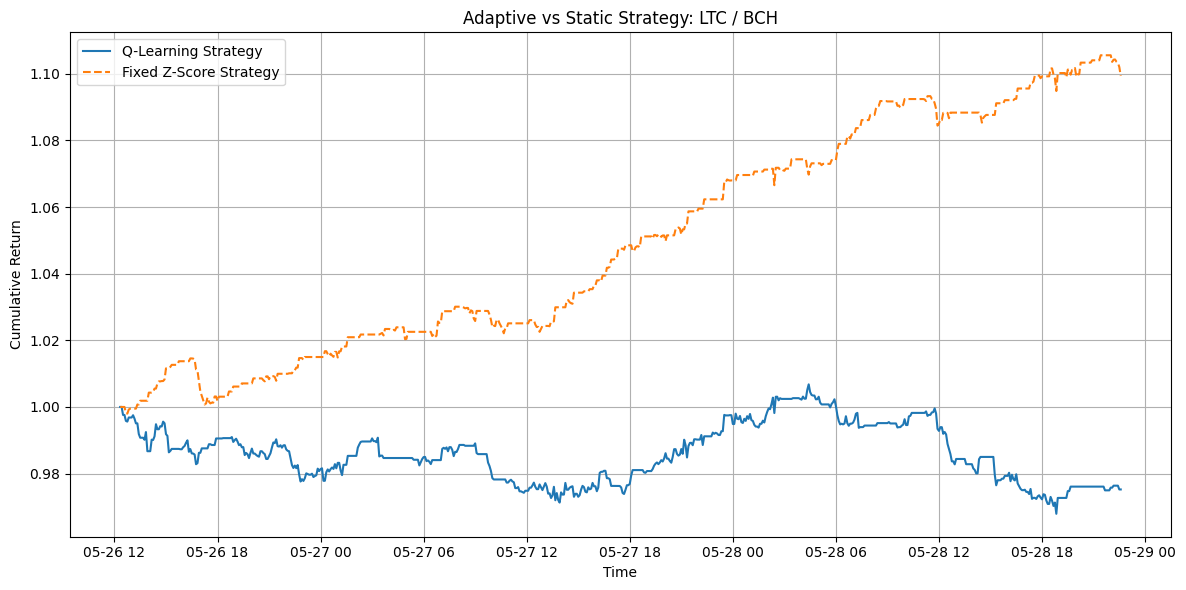

In [ ]:
threshold = merged['z_score'].std()
merged['fixed_signal'] = 0
merged.loc[merged['z_score'] > threshold, 'fixed_signal'] = -1
merged.loc[merged['z_score'] < -threshold, 'fixed_signal'] = 1
merged['fixed_return'] = merged['spread_return'] * merged['fixed_signal'].shift()
merged['fixed_cum_return'] = (1 + merged['fixed_return'].fillna(0)).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(merged['rl_cum_return'], label='Q-Learning Strategy')
plt.plot(merged['fixed_cum_return'], label='Fixed Z-Score Strategy', linestyle='--')
plt.title(f"Adaptive vs Static Strategy: {asset1} / {asset2}")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def backtest_metrics(df, label='rl'):
    cum = df[f'{label}_cum_return']
    returns = df[f'{label}_return']
    total_ret = cum.iloc[-1] - 1
    sharpe = returns.mean() / returns.std() * np.sqrt(288)
    drawdown = (cum.cummax() - cum).max()
    print(f"🔹 {label.upper()} Strategy")
    print(f"✅ Total Return: {total_ret:.2%}")
    print(f"📊 Sharpe Ratio: {sharpe:.2f}")
    print(f"📉 Max Drawdown: {drawdown:.2%}\n")

backtest_metrics(merged, 'rl')
backtest_metrics(merged, 'fixed')

🔹 RL Strategy
✅ Total Return: -2.48%
📊 Sharpe Ratio: -0.47
📉 Max Drawdown: 3.89%

🔹 FIXED Strategy
✅ Total Return: 9.93%
📊 Sharpe Ratio: 2.45
📉 Max Drawdown: 1.38%



#NEW DEEP Q LEARNING

In [ ]:
!pip install torch torchvision torchaudio ccxt hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

<ipython-input-14-9cbe04438fa6>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged.loc[:, 'dqn_signal'] = signal_log
<ipython-input-14-9cbe04438fa6>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged.loc[:, 'dqn_return'] = merged['spread_return'] * merged['dqn_signal'].shift()
<ipython-input-14-9cbe04438fa6>:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

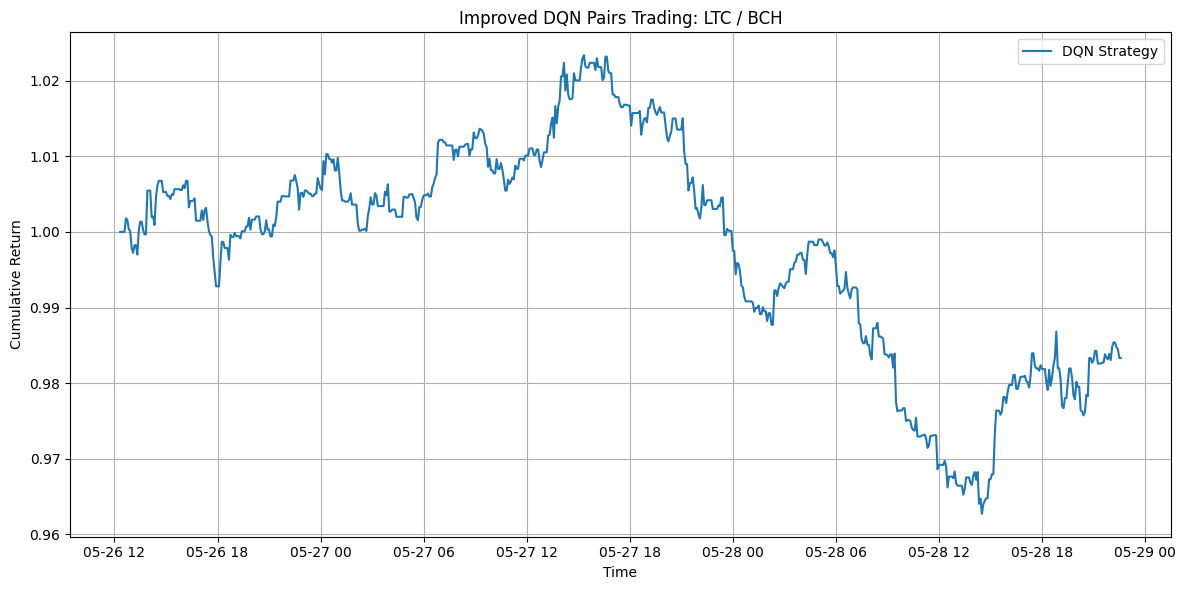

✅ Total Return: -1.67%
📊 Sharpe Ratio: -0.30
📉 Max Drawdown: 6.06%


In [ ]:
# Improved DQN Pairs Trading Strategy (LTC/BCH)

import ccxt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt

# ------------------ 1. Fetch Data ------------------
def fetch_ohlcv(symbol: str, timeframe='5m', limit=30000):
    exchange = ccxt.kraken()
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    return df[['close']]

asset1 = 'LTC'
asset2 = 'BCH'
df1 = fetch_ohlcv(f"{asset1}/USD", limit=30000)
df2 = fetch_ohlcv(f"{asset2}/USD", limit=30000)

# ------------------ 2. Feature Engineering ------------------
merged = pd.merge(df1, df2, left_index=True, right_index=True, suffixes=(f"_{asset1}", f"_{asset2}"))
merged[f'log_{asset1}'] = np.log(merged[f'close_{asset1}'])
merged[f'log_{asset2}'] = np.log(merged[f'close_{asset2}'])
merged['spread'] = merged[f'log_{asset1}'] - merged[f'log_{asset2}']
merged['spread_diff'] = merged['spread'].diff()

merged['volatility'] = merged['spread'].rolling(20).std()
merged['z_score'] = (merged['spread'] - merged['spread'].rolling(20).mean()) / merged['volatility']
merged['momentum'] = merged['spread'].diff(5)
merged = merged.dropna()

# ------------------ 3. Add HMM State ------------------
hmm_model = GaussianHMM(n_components=2, covariance_type="diag", n_iter=1000)
hmm_model.fit(merged[['spread_diff']])
merged.loc[:, 'hmm_state'] = hmm_model.predict(merged[['spread_diff']])

# ------------------ 4. Define DQN ------------------
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )

    def forward(self, x):
        return self.net(x)

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, *transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return map(np.array, zip(*batch))

    def __len__(self):
        return len(self.buffer)

# ------------------ 5. Normalize Inputs ------------------
merged['spread_return'] = (
    merged[f'close_{asset1}'].pct_change() - merged[f'close_{asset2}'].pct_change()
).fillna(0)

state_cols = ['z_score', 'volatility', 'momentum', 'hmm_state']
states = merged[state_cols].astype(np.float32)

X_mean = states.mean()
X_std = states.std()
states = (states - X_mean) / X_std

X = states.values.astype(np.float32)
y = merged['spread_return'].values.astype(np.float32)

# ------------------ 6. DQN Training ------------------
input_dim = X.shape[1]
output_dim = 3  # short, flat, long

dqn = DQN(input_dim, output_dim)
target_dqn = DQN(input_dim, output_dim)
target_dqn.load_state_dict(dqn.state_dict())
optimizer = optim.Adam(dqn.parameters(), lr=0.001)
replay_buffer = ReplayBuffer(20000)

batch_size = 64
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.9995
position = 0

signal_log = []
pnl = []
dqn_losses = []

for t in range(len(X) - 1):
    state = X[t]
    next_state = X[t + 1]

    # Epsilon-greedy action selection
    if random.random() < epsilon:
        action = random.randint(0, output_dim - 1)
    else:
        with torch.no_grad():
            q_vals = dqn(torch.tensor(state))
            action = torch.argmax(q_vals).item()

    new_position = {-1: -1, 0: 0, 1: 1}[action - 1]

    reward = (position * y[t]) - 0.1 * abs(y[t]) - 0.01 * abs(new_position - position)
    done = t == len(X) - 2

    replay_buffer.push(state, action, reward, next_state, done)
    position = new_position
    signal_log.append(position)
    pnl.append(reward)

    # Learning step
    if len(replay_buffer) > batch_size:
        states_b, actions_b, rewards_b, next_states_b, dones_b = replay_buffer.sample(batch_size)

        states_b = torch.tensor(states_b)
        actions_b = torch.tensor(actions_b, dtype=torch.int64).unsqueeze(1)
        rewards_b = torch.tensor(rewards_b, dtype=torch.float32)
        next_states_b = torch.tensor(next_states_b)
        dones_b = torch.tensor(dones_b, dtype=torch.float32)

        q_vals = dqn(states_b).gather(1, actions_b).squeeze()
        with torch.no_grad():
            max_next_q = target_dqn(next_states_b).max(1)[0]
            target = rewards_b + gamma * max_next_q * (1 - dones_b)

        loss = nn.functional.mse_loss(q_vals, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        dqn_losses.append(loss.item())

    if t % 200 == 0:
        target_dqn.load_state_dict(dqn.state_dict())

    epsilon = max(epsilon_min, epsilon * epsilon_decay)

# ------------------ 7. Evaluation ------------------
merged = merged.iloc[1:]
merged.loc[:, 'dqn_signal'] = signal_log
merged.loc[:, 'dqn_return'] = merged['spread_return'] * merged['dqn_signal'].shift()
merged.loc[:, 'dqn_cum_return'] = (1 + merged['dqn_return'].fillna(0)).cumprod()

plt.figure(figsize=(12,6))
plt.plot(merged['dqn_cum_return'], label='DQN Strategy')
plt.title(f"Improved DQN Pairs Trading: {asset1} / {asset2}")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ------------------ 8. Metrics ------------------
def backtest_metrics(df):
    total_ret = df['dqn_cum_return'].iloc[-1] - 1
    sharpe = df['dqn_return'].mean() / df['dqn_return'].std() * np.sqrt(288)
    drawdown = (df['dqn_cum_return'].cummax() - df['dqn_cum_return']).max()
    print(f"✅ Total Return: {total_ret:.2%}")
    print(f"📊 Sharpe Ratio: {sharpe:.2f}")
    print(f"📉 Max Drawdown: {drawdown:.2%}")

backtest_metrics(merged)

#HMM + Bayesian Inference

<ipython-input-19-b4ce4e1c2225>:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged.loc[:, 'dqn_signal'] = signal_log
<ipython-input-19-b4ce4e1c2225>:167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged.loc[:, 'dqn_return'] = merged['spread_return'] * merged['dqn_signal'].shift()
<ipython-input-19-b4ce4e1c2225>:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

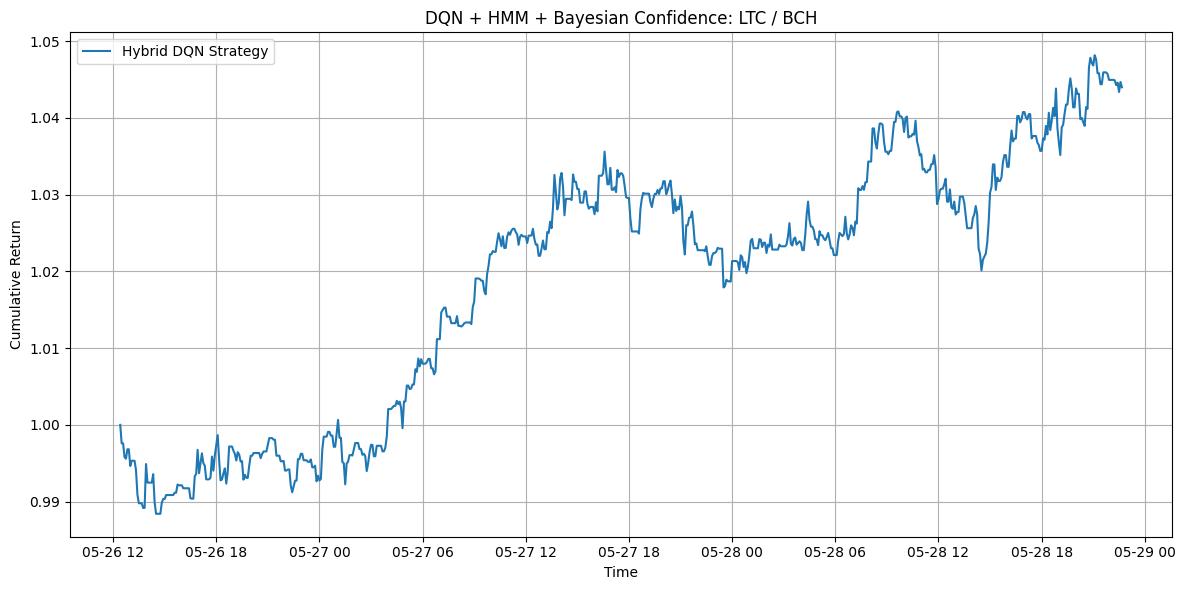

✅ Total Return: 4.40%
📊 Sharpe Ratio: 0.79
📉 Max Drawdown: 2.07%


In [ ]:
# Hybrid Deep Q-Learning + HMM + Bayesian Inference Strategy for LTC/BCH

import ccxt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt

# ------------------ 1. Fetch Data ------------------
def fetch_ohlcv(symbol: str, timeframe='5m', limit=30000):
    exchange = ccxt.kraken()
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    return df[['close']]

asset1 = 'LTC'
asset2 = 'BCH'
df1 = fetch_ohlcv(f"{asset1}/USD", limit=30000)
df2 = fetch_ohlcv(f"{asset2}/USD", limit=30000)

# ------------------ 2. Feature Engineering ------------------
merged = pd.merge(df1, df2, left_index=True, right_index=True, suffixes=(f"_{asset1}", f"_{asset2}"))
merged[f'log_{asset1}'] = np.log(merged[f'close_{asset1}'])
merged[f'log_{asset2}'] = np.log(merged[f'close_{asset2}'])
merged['spread'] = merged[f'log_{asset1}'] - merged[f'log_{asset2}']
merged['spread_diff'] = merged['spread'].diff()

merged['volatility'] = merged['spread'].rolling(20).std()
merged['z_score'] = (merged['spread'] - merged['spread'].rolling(20).mean()) / merged['volatility']
merged['momentum'] = merged['spread'].diff(5)
merged = merged.dropna()

# ------------------ 3. HMM Regime Detection ------------------
hmm_model = GaussianHMM(n_components=2, covariance_type="diag", n_iter=1000)
hmm_model.fit(merged[['spread_diff']])
merged.loc[:, 'hmm_state'] = hmm_model.predict(merged[['spread_diff']])

# ------------------ 4. Bayesian Inference (Simple Confidence) ------------------
def compute_bayesian_confidence(series, window=20):
    confidence = []
    for i in range(len(series)):
        if i < window:
            confidence.append(0.5)
        else:
            wins = (series[i - window:i] > 0).sum()
            alpha = wins + 1
            beta = window - wins + 1
            conf = alpha / (alpha + beta)  # Posterior mean of Beta dist
            confidence.append(conf)
    return pd.Series(confidence, index=series.index)

merged.loc[:, 'bayes_conf'] = compute_bayesian_confidence(merged['spread_diff'])

# ------------------ 5. DQN Setup ------------------
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )
    def forward(self, x):
        return self.net(x)

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    def push(self, *transition):
        self.buffer.append(transition)
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return map(np.array, zip(*batch))
    def __len__(self):
        return len(self.buffer)

# ------------------ 6. Train DQN ------------------
merged['spread_return'] = (
    merged[f'close_{asset1}'].pct_change() - merged[f'close_{asset2}'].pct_change()
).fillna(0)

state_cols = ['z_score', 'volatility', 'momentum', 'hmm_state', 'bayes_conf']
states = merged[state_cols].astype(np.float32)
X_mean = states.mean()
X_std = states.std()
states = (states - X_mean) / X_std

X = states.values.astype(np.float32)
y = merged['spread_return'].values.astype(np.float32)

input_dim = X.shape[1]
output_dim = 3  # short, flat, long

dqn = DQN(input_dim, output_dim)
target_dqn = DQN(input_dim, output_dim)
target_dqn.load_state_dict(dqn.state_dict())
optimizer = optim.Adam(dqn.parameters(), lr=0.0005)
replay_buffer = ReplayBuffer(20000)

batch_size = 64
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.9992
position = 0
signal_log = []
pnl = []
dqn_losses = []

for t in range(len(X) - 1):
    state = X[t]
    next_state = X[t + 1]

    if random.random() < epsilon:
        action = random.randint(0, output_dim - 1)
    else:
        with torch.no_grad():
            q_vals = dqn(torch.tensor(state))
            action = torch.argmax(q_vals).item()

    new_position = {-1: -1, 0: 0, 1: 1}[action - 1]
    reward = (position * y[t]) - 0.1 * abs(y[t]) - 0.01 * abs(new_position - position)
    reward *= merged['bayes_conf'].iloc[t]  # scale reward by confidence

    done = t == len(X) - 2
    replay_buffer.push(state, action, reward, next_state, done)
    position = new_position
    signal_log.append(position)
    pnl.append(reward)

    if len(replay_buffer) > batch_size:
        states_b, actions_b, rewards_b, next_states_b, dones_b = replay_buffer.sample(batch_size)

        states_b = torch.tensor(states_b)
        actions_b = torch.tensor(actions_b, dtype=torch.int64).unsqueeze(1)
        rewards_b = torch.tensor(rewards_b, dtype=torch.float32)
        next_states_b = torch.tensor(next_states_b)
        dones_b = torch.tensor(dones_b, dtype=torch.float32)

        q_vals = dqn(states_b).gather(1, actions_b).squeeze()
        with torch.no_grad():
            max_next_q = target_dqn(next_states_b).max(1)[0]
            target = rewards_b + gamma * max_next_q * (1 - dones_b)

        loss = nn.functional.mse_loss(q_vals, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        dqn_losses.append(loss.item())

    if t % 200 == 0:
        target_dqn.load_state_dict(dqn.state_dict())
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

# ------------------ 7. Evaluation ------------------
merged = merged.iloc[1:]
merged.loc[:, 'dqn_signal'] = signal_log
merged.loc[:, 'dqn_return'] = merged['spread_return'] * merged['dqn_signal'].shift()
merged.loc[:, 'dqn_cum_return'] = (1 + merged['dqn_return'].fillna(0)).cumprod()

plt.figure(figsize=(12,6))
plt.plot(merged['dqn_cum_return'], label='Hybrid DQN Strategy')
plt.title(f"DQN + HMM + Bayesian Confidence: {asset1} / {asset2}")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ------------------ 8. Metrics ------------------
def backtest_metrics(df):
    total_ret = df['dqn_cum_return'].iloc[-1] - 1
    sharpe = df['dqn_return'].mean() / df['dqn_return'].std() * np.sqrt(288)
    drawdown = (df['dqn_cum_return'].cummax() - df['dqn_cum_return']).max()
    print(f"✅ Total Return: {total_ret:.2%}")
    print(f"📊 Sharpe Ratio: {sharpe:.2f}")
    print(f"📉 Max Drawdown: {drawdown:.2%}")

backtest_metrics(merged)

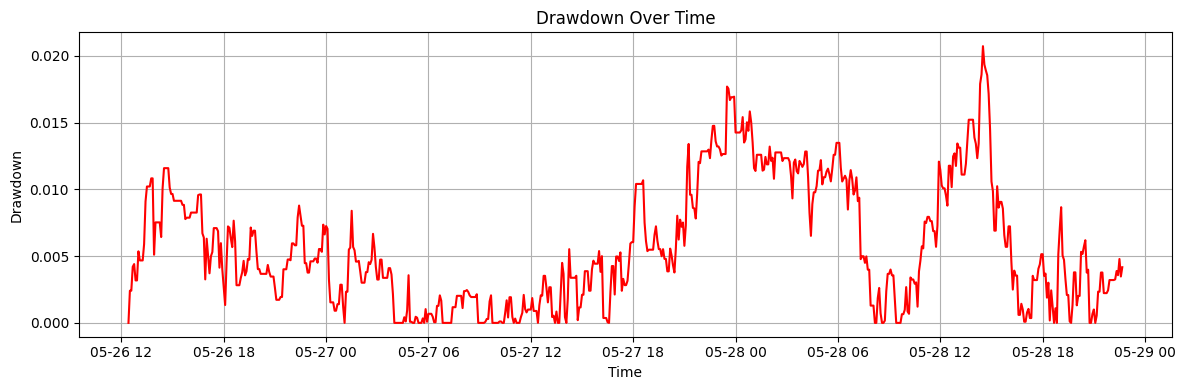

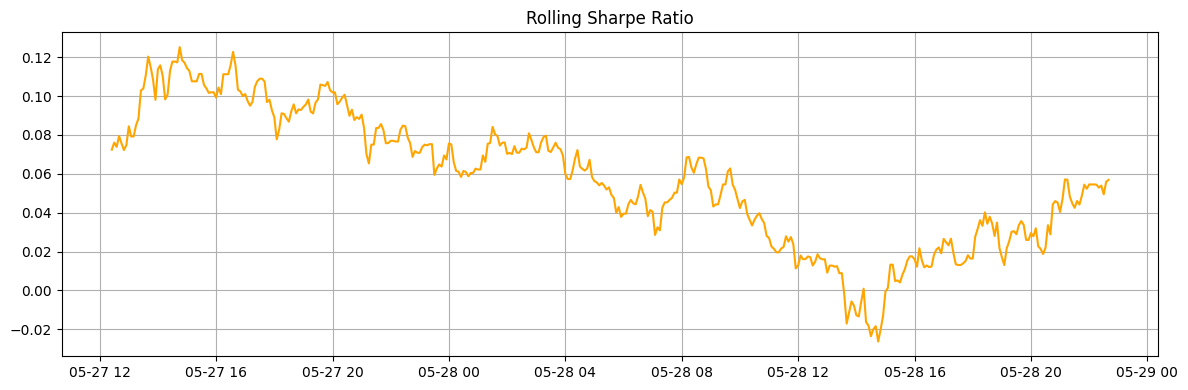

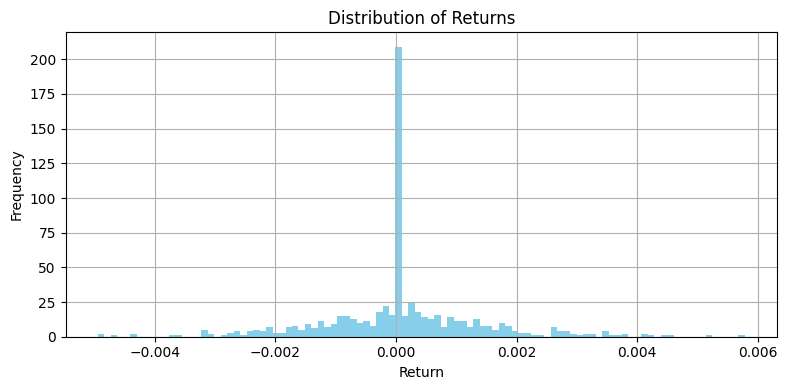

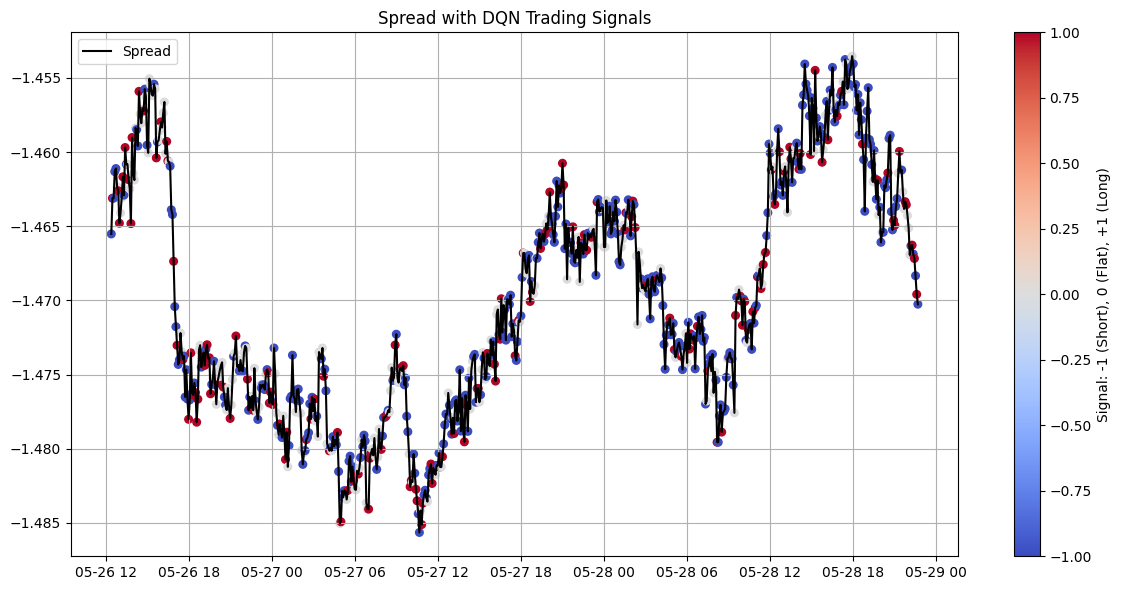

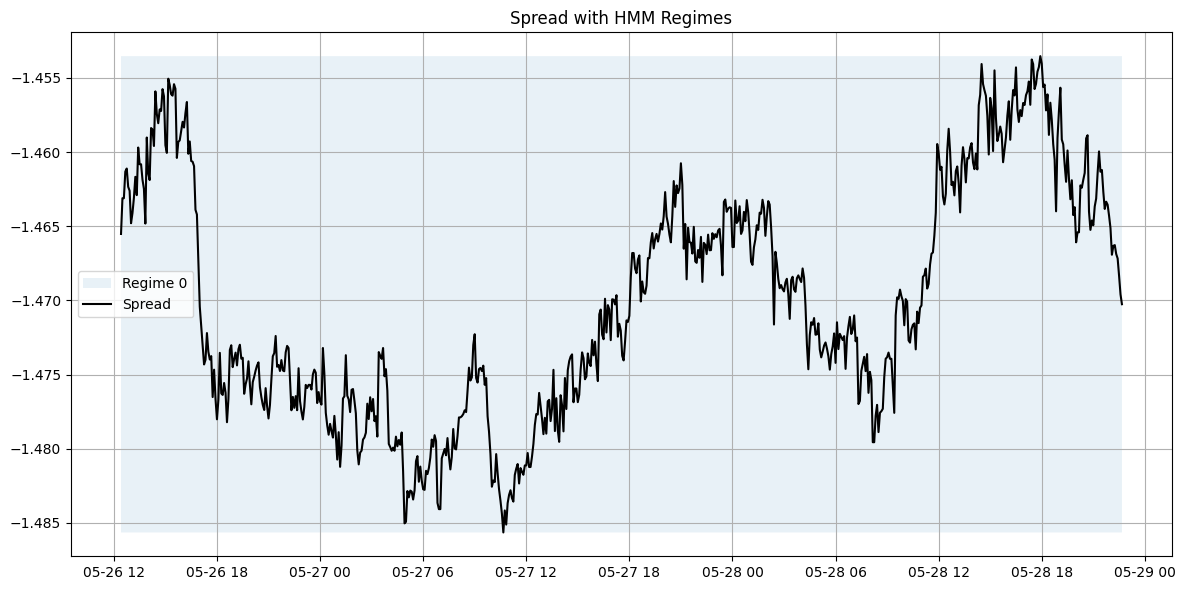

In [ ]:
# 1. Drawdown Chart
drawdown = merged['dqn_cum_return'].cummax() - merged['dqn_cum_return']
plt.figure(figsize=(12, 4))
plt.plot(drawdown, color='red')
plt.title('Drawdown Over Time')
plt.ylabel('Drawdown')
plt.xlabel('Time')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Rolling Sharpe Ratio (1-day = 288 5-minute candles)
rolling_sharpe = (
    merged['dqn_return'].rolling(window=288).mean() /
    merged['dqn_return'].rolling(window=288).std()
)
plt.figure(figsize=(12, 4))
plt.plot(rolling_sharpe, label='Rolling Sharpe (1 Day)', color='orange')
plt.title('Rolling Sharpe Ratio')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Distribution of Returns (Histogram)
plt.figure(figsize=(8, 4))
plt.hist(merged['dqn_return'].dropna(), bins=100, color='skyblue')
plt.title('Distribution of Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Spread with Signal Overlay
plt.figure(figsize=(12, 6))
plt.plot(merged.index, merged['spread'], label='Spread', color='black')
plt.scatter(merged.index, merged['spread'], c=merged['dqn_signal'], cmap='coolwarm', s=30)
plt.title('Spread with DQN Trading Signals')
plt.colorbar(label='Signal: -1 (Short), 0 (Flat), +1 (Long)')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

# 5. HMM State Regime Overlay
plt.figure(figsize=(12, 6))
for state in merged['hmm_state'].unique():
    plt.fill_between(merged.index, merged['spread'].min(), merged['spread'].max(),
                     where=merged['hmm_state'] == state, alpha=0.1, label=f'Regime {state}')
plt.plot(merged['spread'], label='Spread', color='black')
plt.title('Spread with HMM Regimes')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


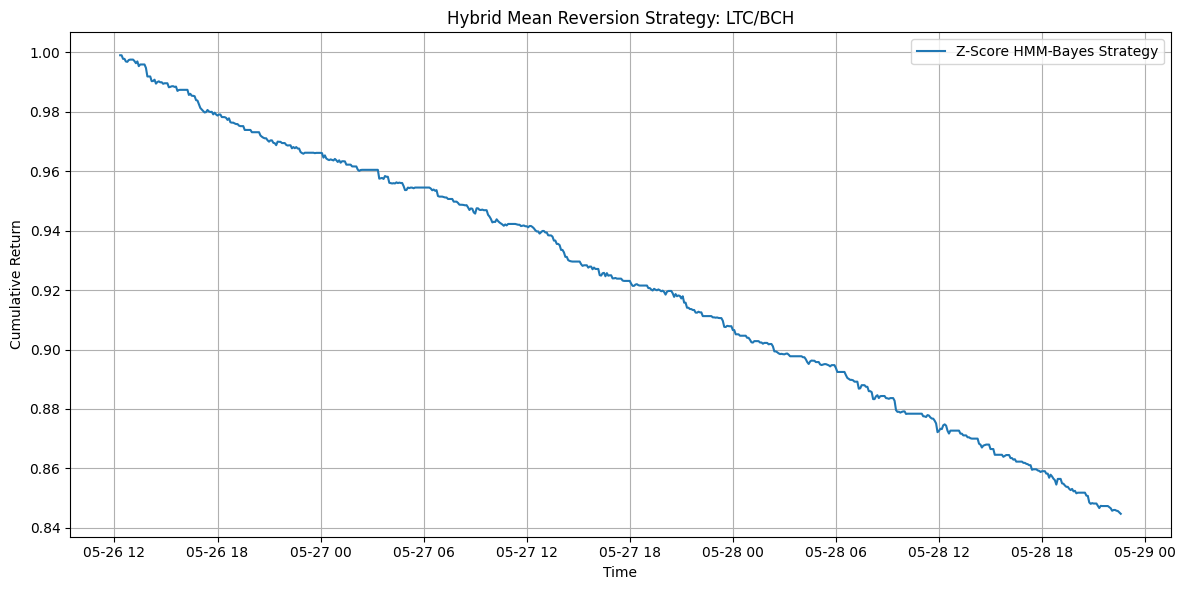

✅ Total Return: -15.53%
📊 Sharpe Ratio: -6.51
📉 Max Drawdown: 15.44%


In [ ]:
# ✅ Mean Reversion Strategy with Z-Score, HMM Regimes, and Bayesian Confidence

import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM

# ------------------ 1. Fetch OHLCV Data ------------------
def fetch_ohlcv(symbol: str, timeframe='5m', limit=3000000):
    exchange = ccxt.kraken()
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    return df[['close']]

asset1 = 'LTC'
asset2 = 'BCH'
df1 = fetch_ohlcv(f"{asset1}/USD")
df2 = fetch_ohlcv(f"{asset2}/USD")

# ------------------ 2. Merge & Feature Engineering ------------------
merged = pd.merge(df1, df2, left_index=True, right_index=True, suffixes=(f"_{asset1}", f"_{asset2}"))
merged[f'log_{asset1}'] = np.log(merged[f'close_{asset1}'])
merged[f'log_{asset2}'] = np.log(merged[f'close_{asset2}'])
merged['spread'] = merged[f'log_{asset1}'] - merged[f'log_{asset2}']
merged['spread_diff'] = merged['spread'].diff()
merged['volatility'] = merged['spread'].rolling(20).std()
merged['z_score'] = (merged['spread'] - merged['spread'].rolling(20).mean()) / merged['volatility']
merged['momentum'] = merged['spread'].diff(5)
merged = merged.dropna()

# ------------------ 3. HMM Regime Detection ------------------
hmm_model = GaussianHMM(n_components=2, covariance_type="diag", n_iter=1000)
hmm_model.fit(merged[['spread_diff']])
merged['hmm_state'] = hmm_model.predict(merged[['spread_diff']])

# ------------------ 4. Bayesian Confidence ------------------
def compute_bayesian_confidence(series, window=20):
    confidence = []
    for i in range(len(series)):
        if i < window:
            confidence.append(0.5)
        else:
            wins = (series[i - window:i] > 0).sum()
            alpha = wins + 1
            beta = window - wins + 1
            conf = alpha / (alpha + beta)
            confidence.append(conf)
    return pd.Series(confidence, index=series.index)

merged['spread_return'] = merged[f'close_{asset1}'].pct_change() - merged[f'close_{asset2}'].pct_change()
merged['spread_return'] = merged['spread_return'].fillna(0)
merged['bayes_conf'] = compute_bayesian_confidence(merged['spread_return'])

# ------------------ 5. Z-Score Threshold Mean Reversion Strategy ------------------
upper_thresh = 0.7
lower_thresh = -0.7

position = 0
signals = []
returns = []

for i in range(1, len(merged)):
    z = merged['z_score'].iloc[i]
    conf = merged['bayes_conf'].iloc[i]
    ret = merged['spread_return'].iloc[i]

    if z > upper_thresh:
        position = -1 * conf
    elif z < lower_thresh:
        position = 1 * conf
    else:
        position = 0

    signals.append(position)
    returns.append(position * ret)

merged = merged.iloc[1:]
merged['signal'] = signals
merged['return'] = returns
merged['cum_return'] = (1 + merged['return'].fillna(0)).cumprod()

# ------------------ 6. Plot & Metrics ------------------
plt.figure(figsize=(12,6))
plt.plot(merged['cum_return'], label='Z-Score HMM-Bayes Strategy')
plt.title(f"Hybrid Mean Reversion Strategy: {asset1}/{asset2}")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

def backtest_metrics(df):
    total_ret = df['cum_return'].iloc[-1] - 1
    sharpe = df['return'].mean() / df['return'].std() * np.sqrt(288)
    drawdown = (df['cum_return'].cummax() - df['cum_return']).max()
    print(f"✅ Total Return: {total_ret:.2%}")
    print(f"📊 Sharpe Ratio: {sharpe:.2f}")
    print(f"📉 Max Drawdown: {drawdown:.2%}")

backtest_metrics(merged)
